<a href="https://colab.research.google.com/github/nile649/Py_CUDA_Tutorials/blob/master/cuda_chp_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Difference between ThreadIdx.x, BloackIdx.x
***
Basically threadIdx.x and threadIdx.y are the numbers associated with each thread within a block. Let’s say you declare your block size to be one dimensional with a size of 8 threads (normally you would want something in multiples of 32 like 192 or 256 depending on your specific code). The variable threadIdx.x would be simultaneously 0,1,2,3,4,5,6 and 7 inside each block. If you declared a two dimensional block size (say (3,3) ) then threadIdx.x would be 0,1,2 and you would now have a threadIdx.y value corresponding to 0,1,2. There are actually nine threads associated with the (3,3) block size. For instance, the thread indices (0,0) (0,1) (1,2) etc refer to independent threads. This convention is very useful for two dimensional applications like working with matrices. Remember, threadIdx.x starts at 0 for each block. Your block can be up to three dimensions which allows for a threadIdx.z index as well.

The blockIdx.x and blockIdx.y refers to the label associated with a block in a grid. You are allowed up to a 2-dimensional grid (allowing for blockIdx.x and blockIdx.y). Basically, the blockIdx.x variable is similar to the thread index except it refers to the number associated with the block.

Let’s say you want 2 blocks in a 1D grid with 5 threads in each block. Your threadIdx.x would be 0, 1,…,4 for each block and your blockIdx.x would be 0 and 1 depending on the specific block.

Now, let’s say you want to load an array of 10 values into a kernel using these two blocks of 5 threads. How would you do this since your thread index only goes 0 - 4 for each block? You would use a third parameter given in CUDA – blockDim.x. This holds the size of the block (in this case blockDim.x = 5). You can refer to the specific element in the array by saying something like…

int idx = blockDim.x*blockIdx.x + threadIdx.x

This makes idx = 0,1,2,3,4 for the first block because blockIdx.x for the first block is 0. The second block picks up where the first left off because blockIdx.x = 1 and blockDim.x = 5. This makes idx = 5,6,7,8,9 for the second block.
***

## Thread synchronization and intercommunication
We'll now discuss two important concepts in GPU programming—thread synchronization
and thread intercommunication.

1. Sometimes, we need to ensure that every single thread has reached to the same exact line of the code before we proceed fruther.
----- We call this has thread synchronization and it goes hand in hand with thread intercommunication

2. Thread intercommunication :-  Different passing thread interacte in way they share data.

CUDA **__syncthreads** device function, which is used for synchronizing a single
block in a kernel.


# Using the __syncthreads() device function

If we use iteration, there could be race case scenario where one thread may reach faster than the other, this could cause problem. In such case, we need to synchronize all the threads.

"this raises the issue of race conditions; this is the issue of multiple threads
reading and writing to the same memory address and the problems that may arise from
that."

This could happen in any scenario from writing in-place, to having iterations based changes.

We can avoid race conditions by
using a CUDA device function called *** __syncthreads().*** This function is a block level
synchronization barrier—this means that every thread that is executing within a block will
stop when it reaches a __syncthreads() instance and wait until each and every other
thread within the same block reaches that same invocation of __syncthreads() before the
the threads continue to execute the subsequent lines of code.

<b style="color:blue">"__syncthreads() can only synchronize threads within a single CUDA
block, not all threads within a CUDA grid!"</b>

In [ ]:
# Conway game of life with synchornize

In [ ]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

Can anyone describe the differences between __global__ and __device__ ?

When should I use __device__, and when to use __global__?.

***
Global functions are also called "kernels". It's the functions that you may call from the host side using CUDA kernel call semantics (<<<...>>>).

Device functions can only be called from other device or global functions. __device__ functions cannot be called from host code.

***

Link : https://stackoverflow.com/questions/12373940/difference-between-global-and-device-functions

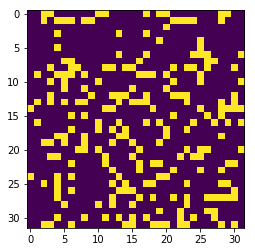

In [ ]:
kernel = SourceModule(
"""
// define index for idx and idy threads for 2D block.

#define _X (threadIdx.x + blockIdx.x*blockDim.x)
#define _Y (threadIdx.y + blockIdx.y*blockDim.y)

// define width and height for the 2D grid
#define _Width (blockDim.x * gridDim.x)
#define _Height (blockDim.y * gridDim.y)

// define index x and y, if they overflow the block ex : 5x5 if the idx increases over 5;

__device__ int _Xm(int x){
    return (x+_Width)%_Width;
    }
__device__ int _Ym(int y){
    return (y+_Height)%_Height;
    }

__device__ int _INDEX(int x, int y){
    return _Xm(x)+_Ym(y)+_Width;
    }
// Since our cell lattice is stored row-wise, we have to multiply the y-value by the width to
// offset to the point corresponding to the appropriate row.

__device__ int nbrs(int X, int Y, int *input){ // inputs are passed as pointers by reference, \
//since c doesn't have pass reference, so we pass by pointer.
    return (input[_INDEX(X-1,Y-1)]+input[_INDEX(X-1,Y)]+input[_INDEX(X-1,Y+1)]\
    +input[_INDEX(X,Y-1)]+input[_INDEX(X,Y+1)]\
    +input[_INDEX(X+1,Y-1)]+input[_INDEX(X+1,Y)]+input[_INDEX(X+1,Y+1)]);
    }
    

// main kernel macro that will be called from host to device.

__global__ void conway_ker(int * lattice, int iters){
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   
   for (int i = 0; i < iters; i++)
   {
   
       // count the number of neighbors around the current cell
       int n = nbrs(x, y, lattice);
       
       int cell_value;
                       
        
        // if the current cell is alive, then determine if it lives or dies for the next generation.
        if ( lattice[_INDEX(x,y)] == 1)
           switch(n)
           {
              // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
              case 2:
              case 3: cell_value = 1;
                      break;
              default: cell_value = 0;                   
           }
        else if( lattice[_INDEX(x,y)] == 0 )
             switch(n)
             {
                // a dead cell comes to life only if it has 3 neighbors that are alive.
                case 3: cell_value = 1;
                        break;
                default: cell_value = 0;         
             }
             
        __syncthreads();
        lattice[_INDEX(x,y)] = cell_value;
        __syncthreads(); 
    }
         
    }
""")


conway_ker = kernel.get_function("conway_ker")
     

    

if __name__ == '__main__':
    # set lattice size
    N = 32
    
    lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
    lattice_gpu = gpuarray.to_gpu(lattice)
    conway_ker(lattice_gpu, np.int32(100000), grid=(2,2,1), block=(32,32,1))
    fig = plt.figure(1)
    plt.imshow(lattice_gpu.get())
    plt.show()

## LINE : _Xm

The _WIDTH and _HEIGHT macros will give us the width and height of our cell lattice,
respectively, which should be clear from the diagrams. Let's discuss the _XM and _YM
macros. In our implementation of LIFE, we'll have the endpoints "wrap around" to the
other side of the lattice—for example, we'll consider the x-value of -1 to be _WIDTH - 1,
and a y-value of -1 to be _HEIGHT - 1, and we'll likewise consider an x-value of _WIDTH
to be 0 and a y-value of _HEIGHT to be 0. Why do we need this? When we calculate the
number of living neighbors of a given cell, we might be at some edge and the neighbors
might be external points—defining these macros to modulate our points will cover this for
us automatically. Notice that we have to add the width or height before we use C's
modulus operator—this is because, unlike Python, the modulus operator in C can return
negative values for integers. 

## 

************
    We now have one final macro to define. We recall that PyCUDA passes two-dimensional
    arrays into CUDA C as one-dimensional pointers; two-dimensional arrays are passed in
    row-wise from Python into one dimensional C pointers. This means that we'll have to
    translate a given Cartesian (x,y) point for a given cell on the lattice into a one dimensional
    point within the pointer corresponding to the lattice. Here, we can do so as follows:

 #define _INDEX(x,y) ( _XM(x) + _YM(y) * _WIDTH )
************


##

***********
A CUDA device function is a serial C function that is called by an
individual CUDA thread from within a kernel. While these functions are
serial in themselves, they can be run in parallel by multiple GPU threads.
Device functions cannot by themselves by launched by a host computer
onto a GPU, only kernels.

***********

# Using shared memory

1. Threads in a block can communicate with each other using GUP's global memory.
2. We can speedup things using shared memory.
3. This is a type of memory meant specifically for intercommunication of threads within a single CUDA block;
4. Shared memory is recommended for a block so that threads can inter-communicate with each other.
5. In contrast to global memory, though, memory stored in shared memory cannot directly be accessed by the host—shared memory must be copied back into global memory by the kernel itself first.


##
***
Local thread arrays (for example, a declaration of int a[10]; within the
kernel) and pointers to global GPU memory (for example, a value passed
as a kernel parameter of the form int * b) may look and act similarly,
but are very different. 

For every thread in the kernel, there will be a separate a array that the other threads cannot read, yet there is a single gloabl b that will hold the same values and be equally accessible for all of the threads.


We are prepared to use shared memory. This allows us to declare variables and arrays that
are shared among the threads within a single CUDA block. This memory is much faster
than using global memory pointers (as we have been using

***

How many thread threads operate on shared memory!!!!!


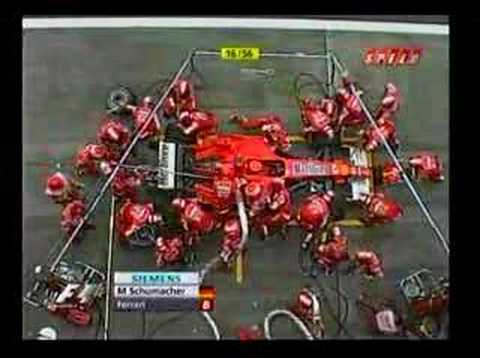

In [ ]:
from IPython.display import Audio,Image, YouTubeVideo
id='UUvagsM176o'
print("How many thread threads operate on shared memory!!!!!")
YouTubeVideo(id=id,width=600,height=300)

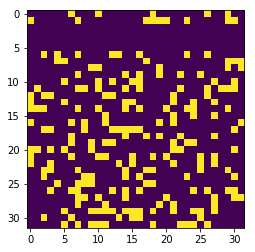

In [ ]:
### WIth shared variable

kernel = SourceModule(
"""
// define index for idx and idy threads for 2D block.

#define _X (threadIdx.x + blockIdx.x*blockDim.x)
#define _Y (threadIdx.y + blockIdx.y*blockDim.y)

// define width and height for the 2D grid
#define _Width (blockDim.x * gridDim.x)
#define _Height (blockDim.y * gridDim.y)

// define index x and y, if they overflow the block ex : 5x5 if the idx increases over 5;

__device__ int _Xm(int x){
    return (x+_Width)%_Width;
    }
__device__ int _Ym(int y){
    return (y+_Height)%_Height;
    }

__device__ int _INDEX(int x, int y){
    return _Xm(x)+_Ym(y)+_Width;
    }
// Since our cell lattice is stored row-wise, we have to multiply the y-value by the width to
// offset to the point corresponding to the appropriate row.

__device__ int nbrs(int X, int Y, int *input){ // inputs are passed as pointers by reference, \
//since c doesn't have pass reference, so we pass by pointer.
    return (input[_INDEX(X-1,Y-1)]+input[_INDEX(X-1,Y)]+input[_INDEX(X-1,Y+1)]\
    +input[_INDEX(X,Y-1)]+input[_INDEX(X,Y+1)]\
    +input[_INDEX(X+1,Y-1)]+input[_INDEX(X+1,Y)]+input[_INDEX(X+1,Y+1)]);
    }
    

// main kernel macro that will be called from host to device.

__global__ void conway_ker(int * lattice_g, int iters){
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   
   __shared__ int lattice_s[32*32];
   
   
   
   // convert a global lattice to shared memory.
   lattice_s[_INDEX(x,y)] = lattice_g[_INDEX(x,y)];
   __syncthreads();
   
   
   for (int i = 0; i < iters; i++)
   {
   
       // count the number of neighbors around the current cell
       int n = nbrs(x, y, lattice_s);
       
       int cell_value;
                       
        
        // if the current cell is alive, then determine if it lives or dies for the next generation.
        if ( lattice_s[_INDEX(x,y)] == 1)
           switch(n)
           {
              // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
              case 2:
              case 3: cell_value = 1;
                      break;
              default: cell_value = 0;                   
           }
        else if( lattice_s[_INDEX(x,y)] == 0 )
             switch(n)
             {
                // a dead cell comes to life only if it has 3 neighbors that are alive.
                case 3: cell_value = 1;
                        break;
                default: cell_value = 0;         
             }
             
        __syncthreads();
        lattice_s[_INDEX(x,y)] = cell_value;
        __syncthreads(); 
    }
    
    __syncthreads();
    lattice_g[_INDEX(x,y)] = lattice_s[_INDEX(x,y)];
    __syncthreads();
    }
""")


conway_ker = kernel.get_function("conway_ker")
     

    

if __name__ == '__main__':
    # set lattice size
    N = 32
    
    lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
    lattice_gpu = gpuarray.to_gpu(lattice)
    conway_ker(lattice_gpu, np.int32(100000), grid=(2,2,1), block=(32,32,1))
    fig = plt.figure(1)
    plt.imshow(lattice_gpu.get())
    plt.show()

## Stackoverflow Explanation 
https://stackoverflow.com/questions/8011376/when-is-cudas-shared-memory-useful